In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from IPython.display import display

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf

Using TensorFlow backend.


# Parameters

In [2]:
#img_rows, img_cols, img_chns = 16, 16, 3
img_rows, img_cols, img_chns = 16, 16, 3
original_img_size = (img_rows, img_cols, img_chns)
pixel_level_divisor = 16
sample = 16

batch_size = int(os.environ.get('BATCH_SIZE', 2))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
decay = float(os.environ.get('DECAY', 0.0))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.0005))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 15))

## Load CIFAR10 dataset

In [3]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train[:sample, :img_rows, :img_cols, :]
#X_train_out = X_train.copy().reshape((X_train.shape[0], -1)) 
X_train_out = []
for i in range(img_rows):
    for j in range(img_cols):
        for k in range(img_chns):
            X_train_out.append((X_train[:, i, j, k] // pixel_level_divisor).copy())
# X_train_out = X_train.copy().reshape((X_train.shape[0], -1)) 
#.reshape((X_train.shape[0], -1, 1))
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test[:, :img_rows, :img_cols, :]
X_test_out = []
for i in range(img_rows):
    for j in range(img_cols):
        for k in range(img_chns):
            X_test_out.append((X_test[:, i, j, k] // pixel_level_divisor).copy())
#X_test_out = X_test.copy().reshape((X_test.shape[0], -1))
#.reshape((X_test.shape[0], -1, 1))
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(len(X_train_out))
print(X_train_out[0].shape)
print(X_test.shape, y_test.shape)
print(len(X_test_out))
print(X_test_out[0].shape)

(16, 16, 16, 3) (50000, 1)
768
(16,)
(10000, 16, 16, 3) (10000, 1)
768
(10000,)


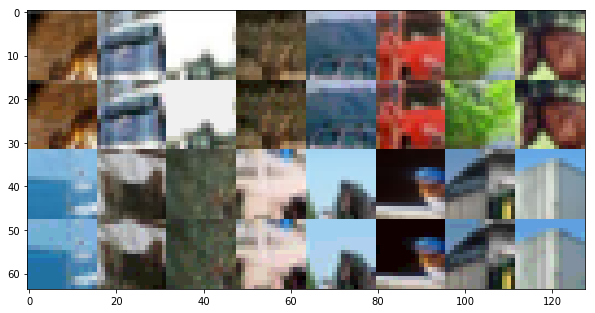

In [4]:
n = 4
figure = np.zeros((img_rows * n, img_cols * n * 2, img_chns))

for i in range(n // 2):
    for j in range(n * 2):
        orig_img = X_train[i * 2 * n + j] 
        d_x = (2 * i) * img_rows 
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = orig_img
        
        # Digitize
        img = ((orig_img * 255. // pixel_level_divisor) * pixel_level_divisor).astype(float) / 255
        figure[d_x + img_rows:d_x + 2 * img_rows, d_y:d_y + img_cols] = img
        #print(img)
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

In [5]:
class PixelConv2D(Conv2D):
    def __init__(self, ptype, *args, **kwargs):
        # ptype corresponds to pixel type and mask type, e.g. ra, ga, ba, rb, gb, bb
        assert ptype[0] in ['r', 'g', 'b'], ptype
        assert ptype[1] in ['a', 'b'], ptype
        self.ptype = ptype
        super(PixelConv2D, self).__init__(*args, **kwargs)
       
    def build_mask(self, kernel_shape):
        # kernel_shape = kern_dim x kern_dim x total_filters
        #              = kern_dim x kern_dim x r_g_b_filters x filters_per_channel
        assert kernel_shape[0] == kernel_shape[1], "{} must be equal in first two dims".format(kernel_shape)
        assert kernel_shape[0] % 2 == 1, "{} must be odd size in first two dims".format(kernel_shape)
        assert kernel_shape[2] % 3 == 0, "{} must be divisible by 3".format(kernel_shape)
        data = np.ones(kernel_shape)
        
        data.shape
        mid = data.shape[0] // 2
        if self.ptype[0] == 'r':
            filt_prev = 0
            filt_thres = int(data.shape[2] / 3)
        elif self.ptype[0] == 'g':
            filt_prev = int(data.shape[2] / 3)
            filt_thres = int(2 * data.shape[2] / 3)
        else:
            assert self.ptype[0] == 'b', self.ptype
            filt_prev = int(2 * data.shape[2] / 3)
            filt_thres = data.shape[2]
            
        # print(data.shape, self.ptype, mid, filt_prev, filt_thres)
        
        for k1 in range(data.shape[0]):
            for k2 in range(data.shape[1]):
                for chan in range(data.shape[2]):
                    for filt in range(data.shape[3]):
                        if self.ptype[1] == 'a' and chan >= filt_prev:
                            if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
                                data[k1, k2, chan, filt] = 0
                        else:
                            if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
                                data[k1, k2, chan, filt] = 0
            
        return K.constant(np.ravel(data), dtype='float32', shape=kernel_shape)
       
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_mask = self.build_mask(kernel_shape)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        masked_kernel = self.kernel * self.kernel_mask
        outputs = K.conv2d(
            inputs,
            masked_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs

# Model

In [6]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '2a')
    x = conv_block(x, filters2, (3, 3), name=name_base + '2b')
    x = conv_block(x, filters3, (1, 1), name=name_base + '2c')
    x = Add()([x, input_tensor])
    
    return x

In [7]:
def pixelcnn_loss(target, output):
    # return sparse_categorical_crossentropy(target, output)
    # Note: tf.nn.sparse_softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    # output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    # output = tf.log(output)
    
    # print(target.shape, output.shape)
    # output_shape = output.get_shape()
    targets = tf.cast(target, 'int64')
    targets = tf.reshape(targets, (-1,))
    # logits = tf.reshape(output, [-1, int(output_shape[-1])])
    res = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=output)
    
    return tf.reduce_mean(res)

    #print(x_img.shape, model_softmax_outputs.shape)
    #return -K.mean(x_img * K.log(model_softmax_outputs + (1. - x_img)), axis=-1)
    # TODO, need to unpack x_img_labels and softmax it with model_softmax_outputs
    # x = K.flatten(x_img)
    # for i in range(img_rows * img_cols * img_chns):
    #     out = model_softmax_outputs[i*256:(i+1)*256]
    #     loss += sparse_categorical_crossentropy(x[i], out)
    #     if i % 100 == 0:
    #         print(i)
    # return loss / (img_rows * img_cols * img_chns)


def data_generator(X_data, X_data_out, batch_size):
    while True:
        index = np.arange(len(X_data))
        np.random.shuffle(index)
        for i in range(len(X_data) // batch_size):
            batch_in_data = X_data[index[i * batch_size: (i+1)*batch_size], :, :, :]
            batch_out_data = X_data_out[index[i * batch_size: (i+1)*batch_size], :, :]
            yield batch_in_data, to_categorical(batch_out_data, num_classes=256).reshape(batch_size, -1)
            
#for x, y in data_generator(X_test, X_test_out, 1):
#    print(x.shape, y.shape)
#    break

In [8]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')

final_filters = 300
x = conv_block(x, final_filters, (1, 1), name='final_1x1_1024_1')
x = conv_block(x, final_filters, (1, 1), name='final_1x1_1024_2')

# Output layer - one softmax per R*G*B pixels
print("Building output layers...")
outputs = []
for k1 in range(img_rows):
    for k2 in range(img_cols):
        for channel in range(img_chns):
            out = Lambda(lambda x: x[:, k1, k2, channel * final_filters:(channel + 1) * final_filters])(x)
            out = Dense(256 // pixel_level_divisor, kernel_regularizer=l2(0.001), 
                        bias_regularizer=l2(0.001))(out)
            outputs.append(out)

#main_output = Concatenate()(outputs)
#main_output = Reshape(original_img_size + (256,))(main_output)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
model.summary()

Building conv layers...
Building output layers...
Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 16, 16, 3)     0                                            
____________________________________________________________________________________________________
resconv1ra (PixelConv2D)         (None, 16, 16, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ga (PixelConv2D)         (None, 16, 16, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ba (PixelConv2D)         (None, 16, 16, 256)   37888       main_input[0][0]                 
_______________________

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=0.1, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.25, patience=20, min_lr=0.01 * learning_rate)
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001 * learning_rate)

#history = model.fit_generator(
#    data_generator(X_train, X_train_out, batch_size),
#    #batch_size=batch_size,
#    epochs=epochs,
#    steps_per_epoch=len(X_train) // batch_size,
#    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
#    validation_data=data_generator(X_test, X_test_out, batch_size),
#    validation_steps=len(X_test) // batch_size,
#    max_queue_size=32,
#    #verbose=2
#)


class MyTQDMNotebookCallback(TQDMNotebookCallback):
    def format_metrics(self, logs):
        metrics = self.params['metrics']
        strings = []
        for i, metric in enumerate(metrics):
            if metric in logs:
                strings.append(self.metric_format.format(name=metric, value=np.mean(logs[metric], axis=None)))
                if i >= 6:
                    break
        return self.separator.join(strings)

history = model.fit(
    X_train, X_train_out,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[MyTQDMNotebookCallback(), early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    verbose=0
)


done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  2782.424930334091


,dense_100_loss,dense_101_loss,dense_102_loss,dense_103_loss,dense_104_loss,dense_105_loss,dense_106_loss,dense_107_loss,dense_108_loss,dense_109_loss,...,dense_93_loss,dense_94_loss,dense_95_loss,dense_96_loss,dense_97_loss,dense_98_loss,dense_99_loss,dense_9_loss,loss,lr
count,370.000000,3.700000e+02,3.700000e+02,370.000000,370.000000,3.700000e+02,370.000000,3.700000e+02,3.700000e+02,370.000000,...,3.700000e+02,370.000000,370.000000,3.700000e+02,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.718447,3.811636e-01,3.531933e-01,0.708811,0.430012,3.307718e-01,0.699490,3.818156e-01,3.325374e-01,0.703774,...,2.627657e-01,0.934264,0.393726,2.489533e-01,0.602314,0.443087,0.345104,0.455878,341.341611,0.000321
std,0.743369,6.545306e-01,6.571792e-01,0.727232,0.677568,6.696993e-01,0.792845,6.762840e-01,6.835994e-01,0.763815,...,5.808601e-01,0.730690,0.660343,5.364900e-01,0.713481,0.685764,0.630623,0.700151,479.716831,0.000198
min,0.005736,5.587925e-07,3.576270e-07,0.001822,0.000001,7.152529e-07,0.000174,1.043081e-07,1.117586e-07,0.010092,...,2.235174e-08,0.034378,0.000020,3.278252e-07,0.000075,0.000090,0.000005,0.000432,19.455742,0.000008
0%,0.005736,5.587925e-07,3.576270e-07,0.001822,0.000001,7.152529e-07,0.000174,1.043081e-07,1.117586e-07,0.010092,...,2.235174e-08,0.034378,0.000020,3.278252e-07,0.000075,0.000090,0.000005,0.000432,19.455742,0.000008
25%,0.095419,3.169424e-04,2.339428e-04,0.104834,0.001267,1.339390e-04,0.023189,2.272718e-04,2.493406e-04,0.078422,...,4.809816e-05,0.341040,0.001645,5.786933e-05,0.010472,0.001684,0.000761,0.007992,42.702555,0.000125
50%,0.536152,7.841274e-03,5.099140e-03,0.537540,0.016042,3.278657e-03,0.393853,6.357541e-03,3.648005e-03,0.335494,...,3.350051e-03,0.832996,0.026162,1.291847e-03,0.349180,0.026486,0.008477,0.073488,155.325047,0.000500
75%,1.047184,5.022928e-01,3.091628e-01,1.040949,0.549265,2.273142e-01,1.089172,4.981979e-01,2.259010e-01,1.136175,...,1.706133e-01,1.305701,0.494367,1.654246e-01,0.880707,0.681266,0.368479,0.678327,360.873612,0.000500
95%,2.216173,2.076925e+00,2.086257e+00,2.236416,2.154319,2.144281e+00,2.371182,2.263850e+00,2.153626e+00,2.277947,...,1.836240e+00,2.381973,2.130890,1.634226e+00,2.086017,2.150608,1.996460,2.300926,1623.392423,0.000500
99%,2.761965,2.517819e+00,2.568492e+00,2.681013,2.530304,2.591679e+00,2.656181,2.576978e+00,2.702790e+00,2.539105,...,2.511593e+00,2.646791,2.616074,2.322759e+00,2.561771,2.622607,2.425027,2.739735,1946.440139,0.000500


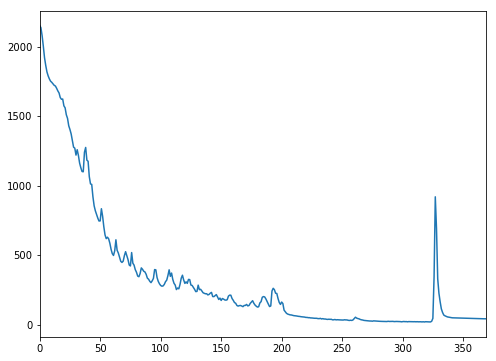

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [11]:
x_eval_out = []
for i in range(len(X_train_out)):
    x_eval_out.append(X_train_out[i])

lossvals = model.evaluate(X_train, x_eval_out)
#print(model.metrics_names)
print(lossvals)

16/16 [==============================] - 8s
[42.1998291015625, 2.0142300128936768, 1.1603701114654541, 0.40038624405860901, 0.70043289661407471, 0.26806658506393433, 0.073301665484905243, 0.31569692492485046, 0.050857905298471451, 0.007114773616194725, 0.31399816274642944, 0.081010743975639343, 0.0077035324648022652, 0.37124291062355042, 0.027884162962436676, 0.0034284261055290699, 0.46396875381469727, 0.037267092615365982, 0.0029648826457560062, 0.36929219961166382, 0.015860952436923981, 0.0047262860462069511, 0.46943467855453491, 0.024209856986999512, 0.0057401512749493122, 0.51198244094848633, 0.072201520204544067, 0.010403867810964584, 0.40797054767608643, 0.043372832238674164, 0.0029786063823848963, 0.33123093843460083, 0.0099713690578937531, 0.0053360788151621819, 0.25046360492706299, 0.011198777705430984, 0.0041370200924575329, 0.35131406784057617, 0.0079631339758634567, 0.0076639698818325996, 0.35250464081764221, 0.013096220791339874, 0.0022002910263836384, 0.45875972509384155,

row 0
row 1
row 2
row 3
row 4
row 5
row 6
row 7
row 8
row 9
row 10
row 11
row 12
row 13
row 14
row 15


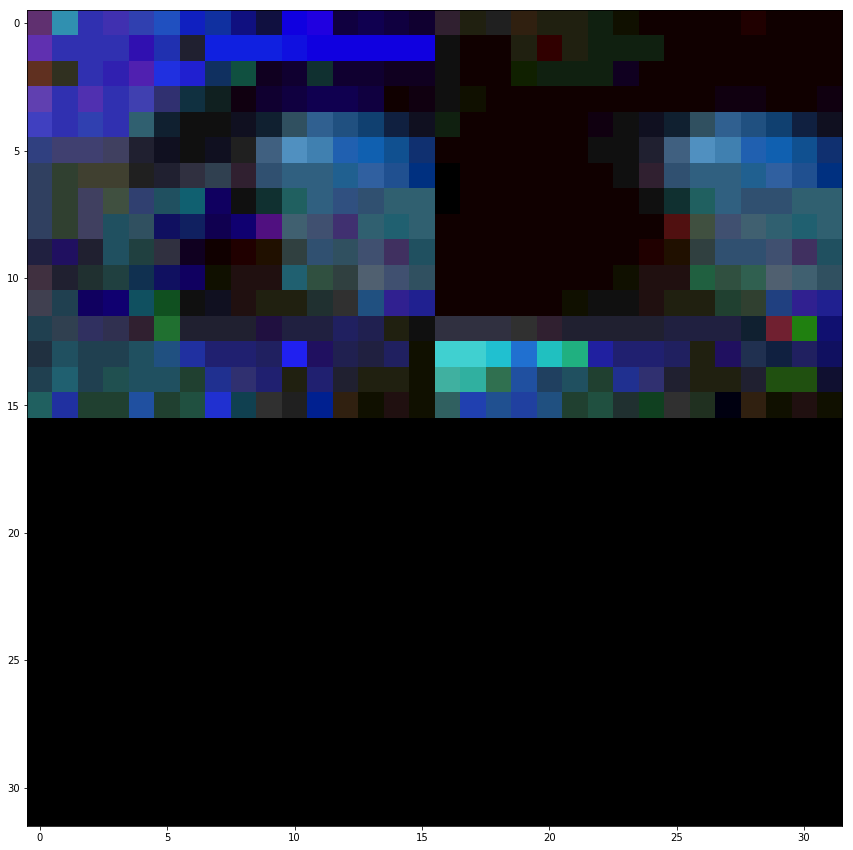

Elapsed:  65.13941383361816


In [12]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                index = i * img_cols * img_chns + j * img_chns + k
                for n in range(num_samples):
                    pvals = softmax(x_out[index][n])
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val * pixel_level_divisor / 255.
                    #print("====", i, j, k, pixel_val, x_sample[n, i, j, k])
                    #print("    ", x_out[index][n])
                    #print("    ", pvals)
                    #print("    ", draw)
                    #print(pixel_val, x_sample[n, i, j, k])
                    #break
        print("row", i)
        #if i >= 1:
        #    break
                
    return x_sample


start = time.time()

n = batch_size
figure = np.zeros((img_rows * n, img_cols * n, img_chns))
for i in range(1):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        # print(img)
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = img
        
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [13]:
orig_img

array([[[ 0.39215686,  0.65882353,  0.90588235],
        [ 0.39215686,  0.65882353,  0.89803922],
        [ 0.39607843,  0.65490196,  0.90196078],
        [ 0.4       ,  0.65098039,  0.90196078],
        [ 0.39607843,  0.65882353,  0.89411765],
        [ 0.39607843,  0.65882353,  0.88627451],
        [ 0.40784314,  0.65098039,  0.90980392],
        [ 0.4       ,  0.65490196,  0.91372549],
        [ 0.38431373,  0.65882353,  0.90196078],
        [ 0.38039216,  0.6627451 ,  0.90196078],
        [ 0.38823529,  0.65490196,  0.90196078],
        [ 0.38823529,  0.65490196,  0.89803922],
        [ 0.38823529,  0.65490196,  0.89803922],
        [ 0.38431373,  0.65490196,  0.89803922],
        [ 0.38431373,  0.65490196,  0.89803922],
        [ 0.38431373,  0.65490196,  0.90196078]],

       [[ 0.40392157,  0.66666667,  0.90196078],
        [ 0.40392157,  0.65882353,  0.89411765],
        [ 0.40784314,  0.65882353,  0.88627451],
        [ 0.40392157,  0.65490196,  0.89411765],
        [ 0.392156

In [14]:
#if os.environ.get('OUTDIR', None):
#    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
#    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))
#
#    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
#    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
#        json.dump(vals, f)

In [15]:
#data = np.ones([3, 3, 6, 1])
#
#data.shape
#ptype = 'ba'
#mid = data.shape[0] // 2
#if ptype[0] == 'r':
#    filt_prev = 0
#    filt_thres = int(data.shape[2] / 3)
#elif ptype[0] == 'g':
#    filt_prev = int(data.shape[2] / 3)
#    filt_thres = int(2 * data.shape[2] / 3)
#else:
#    filt_prev = int(2 * data.shape[2] / 3)
#    filt_thres = data.shape[2]
#    
#print(data.shape, ptype, mid, filt_prev, filt_thres)
#
#for k1 in range(data.shape[0]):
#    for k2 in range(data.shape[1]):
#        for chan in range(data.shape[2]):
#            for filt in range(data.shape[3]):
#                if ptype[1] == 'a' and chan >= filt_prev:
#                    if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#                else:
#                    if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#    
#print(data[:, :, 0, 0])
#print(data[:, :, filt_thres-1, 0])
#data

(3, 3, 6, 1) ba 1 4 6
[[ 1.  1.  1.]
 [ 1.  1.  0.]
 [ 0.  0.  0.]]
[[ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]]


array([[[[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]],

        [[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]],

        [[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]]],


       [[[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]],

        [[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.]]],


       [[[ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.],
         [ 0.]]]])